# **Análisis funcional de genes**

Este trabajo es parte de mi roceso de aprendizaje en la asignatura de Herramientas y Algoritmos en Bioinformática, en este trabajo me basaré en el [código](https://amoyag.github.io/HAB/functional_analysis) de mi profesor Moya García Aurelio con perfil en github de [amoyag](https://github.com/amoyag/HAB)

Introducción al análisis funcional en bioinformática


El análisis funcional en bioinformática busca entender el rol de genes o proteínas en procesos biológicos. Un método común es el análisis de sobrerrepresentación, que compara funciones biológicas enriquecidas en un grupo de genes de interés frente a un grupo de referencia.

Para esto, se usa la prueba exacta de Fisher, que evalúa si la proporción de genes de interés con una función específica es mayor que en el grupo de referencia. El resultado indica si esa función está significativamente sobrerrepresentada en el grupo estudiado.

La fórmula para calcular el valor p con la prueba exacta de Fisher es:
 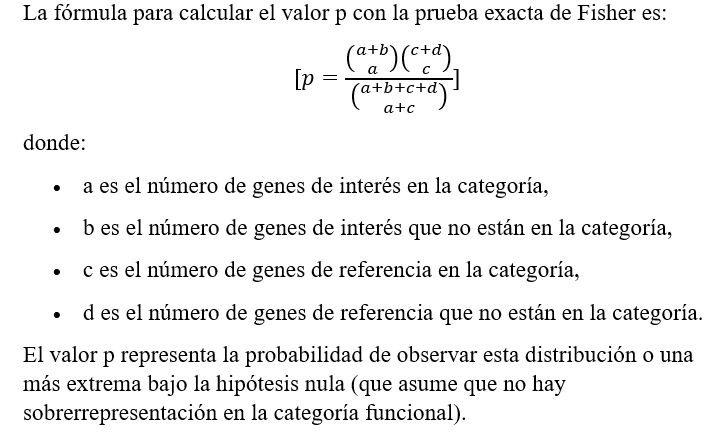


El valor p de la prueba exacta de Fisher puede ser muy pequeño, indicando una sobrerrepresentación significativa. Para controlar la tasa de descubrimientos falsos, se aplica una corrección del p-valor, como el método de Benjamini-Hochberg.

El Gene Set Enrichment Analysis (GSEA) identifica diferencias significativas en un conjunto de genes entre dos estados biológicos. A diferencia del análisis de sobrerrepresentación, GSEA analiza todos los genes según su nivel de expresión, capturando cambios sutiles en genes relacionados. Utiliza pruebas de permutación para evaluar la significancia.

El análisis funcional convierte grandes volúmenes de datos genómicos en información biológica significativa, y hay herramientas en Python que simplifican este proceso.

## **Biopython**

es una herramienta para la computación biológica que ofrece funciones para análisis de secuencias, consultas a bases de datos y recuperación de anotaciones. Aunque no es específicamente para análisis funcional, permite obtener datos como anotaciones funcionales, términos GO y rutas biológicas, siendo útil para complementar otros programas especializados en análisis funcional.

In [11]:
try:
    from Bio import Entrez
except ModuleNotFoundError:
    # Si no está instalado Biopython, se instala automáticamente
    !pip install biopython
    from Bio import Entrez

import time

# Use Entrez to search for genes and fetch their functional annotations
Entrez.email = "your_email@example.com"

# Define the list of glycolysis genes
gene_symbols = ["GAPDH", "PKM", "ALDOA", "HK1", "PFKM", "LDHA"]

# Iterate over each gene to fetch annotations
for gene in gene_symbols:
    try:
        # Search for the gene in Entrez
        handle = Entrez.esearch(db="gene", term=f"{gene}[Gene] AND Homo sapiens[Organism]")
        record = Entrez.read(handle)
        handle.close()

        if record['IdList']:
            gene_id = record['IdList'][0]

            # Fetch the gene summary to get functional annotations
            handle = Entrez.efetch(db="gene", id=gene_id, rettype="gb", retmode="text")
            gene_record = handle.read()
            handle.close()

            # Print the fetched annotation
            print(f"Annotations for {gene}:\n")
            print(gene_record)
            print("\n" + "="*50 + "\n")
        else:
            print(f"No record found for gene: {gene}")

        # Pause to avoid overwhelming the Entrez servers
        time.sleep(1)

    except Exception as e:
        print(f"An error occurred while fetching annotations for {gene}: {e}")

Annotations for GAPDH:


1. GAPDH
Official Symbol: GAPDH and Name: glyceraldehyde-3-phosphate dehydrogenase [Homo sapiens (human)]
Other Aliases: G3PD, GAPD, HEL-S-162eP
Other Designations: glyceraldehyde-3-phosphate dehydrogenase; OCAS, p38 component; Oct1 coactivator in S phase, 38 Kd component; aging-associated gene 9 protein; epididymis secretory sperm binding protein Li 162eP; peptidyl-cysteine S-nitrosylase GAPDH
Chromosome: 12; Location: 12p13.31
Annotation: Chromosome 12 NC_000012.12 (6534517..6538371)
MIM: 138400
ID: 2597




Annotations for PKM:


1. PKM
Official Symbol: PKM and Name: pyruvate kinase M1/2 [Homo sapiens (human)]
Other Aliases: CTHBP, HEL-S-30, OIP3, PK32, TCB, THBP1, p58, PKM
Other Designations: pyruvate kinase PKM; OPA-interacting protein 3; PK, muscle type; cytosolic thyroid hormone-binding protein; epididymis secretory protein Li 30; pyruvate kinase 2/3; pyruvate kinase isozymes M1/M2; pyruvate kinase muscle isozyme; pyruvate kinase, muscle; threonine-prote

## **GOATOOLS**
es una biblioteca de Python que ayuda con el análisis de enriquecimiento de Gene Ontology (GO). Permite a los investigadores realizar análisis estadísticos sobre un conjunto de genes para determinar qué procesos biológicos, componentes celulares o funciones moleculares se enriquecen significativamente.

In [12]:
try:
    from goatools import obo_parser
except ModuleNotFoundError:
    # Si no está instalado goatools, se instala automáticamente
    !pip install goatools
    from goatools import obo_parser

from goatools.go_enrichment import GOEnrichmentStudy
from goatools.associations import read_gaf
import random
import requests
import gzip
import shutil
import os
!pip install mygene
import mygene

### Download stuff

## Get the GO ontology obo file
# URL of the go-basic.obo file
obo_url = "http://current.geneontology.org/ontology/go-basic.obo"
obo_file_path = "go-basic.obo"

# Download only if the file does not already exist
if not os.path.exists(obo_file_path):
    try:
        response = requests.get(obo_url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        with open(obo_file_path, 'wb') as file:
            file.write(response.content)
        print(f"Successfully downloaded 'go-basic.obo' to {obo_file_path}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the file: {e}")
else:
    print(f"'{obo_file_path}' already exists. Skipping download.")

## Download the GAF file
# URL of the goa_human.gaf file
gaf_url = "http://current.geneontology.org/annotations/goa_human.gaf.gz"
compressed_gaf_file_path = "goa_human.gaf.gz"
extracted_gaf_file_path = "goa_human.gaf"

# Download and extract only if the file does not already exist
if not os.path.exists(extracted_gaf_file_path):
    try:
        response = requests.get(gaf_url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        with open(compressed_gaf_file_path, 'wb') as file:
            file.write(response.content)
        print(f"Successfully downloaded 'goa_human.gaf.gz' to {compressed_gaf_file_path}")

        # Extract the .gz file
        with gzip.open(compressed_gaf_file_path, 'rb') as f_in:
            with open(extracted_gaf_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"Successfully extracted '{extracted_gaf_file_path}'")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the file: {e}")
else:
    print(f"'{extracted_gaf_file_path}' already exists. Skipping download.")

### Convert genes ID to UniProt ID
# Initialize MyGene client
mg = mygene.MyGeneInfo()

# Convert gene symbols to UniProt IDs
gene_symbols = ["GAPDH", "PKM", "ALDOA", "HK1", "PFKM", "LDHA"]
query_result = mg.querymany(gene_symbols, scopes='symbol', fields='uniprot', species='human')

# Extract UniProt IDs for the study genes
study_gene_uniprot_ids = []
for gene in query_result:
    uniprot_id = gene.get('uniprot', {}).get('Swiss-Prot')
    if uniprot_id:
        study_gene_uniprot_ids.append(uniprot_id)

# Print the UniProt IDs for each gene
print("Converted UniProt IDs for the study genes:")
for gene_symbol, uniprot_id in zip(gene_symbols, study_gene_uniprot_ids):
    print(f"Gene Symbol: {gene_symbol}, UniProt ID: {uniprot_id}")

### Set the background list and perform ORA

# Extract all genes from the GAF file
all_genes = set()

try:
    with open(extracted_gaf_file_path, 'r') as gaf_file:
        for line in gaf_file:
            # Skip comments
            if line.startswith("!"):
                continue

            # Split the GAF line by tab
            columns = line.strip().split("\t")

            # Column 2 contains the systematic identifier (e.g., UniProt ID)
            gene_identifier = columns[1]

            # Add the gene identifier to the set of all genes
            all_genes.add(gene_identifier)

    print(f"Successfully extracted {len(all_genes)} gene identifiers from the GAF file.")

except FileNotFoundError:
    print(f"File '{extracted_gaf_file_path}' not found. Please make sure it is available.")
except Exception as e:
    print(f"An error occurred while reading the GAF file: {e}")

# Convert to list for sampling
all_genes_list = list(all_genes)

# Randomly sample 1000 genes from the full list
random.seed(42)  # Set seed for reproducibility
background_gene_list = random.sample(all_genes_list, 1000)

# Ensure that all study genes are included in the background list
for gene in study_gene_uniprot_ids:
    if gene not in background_gene_list:
        background_gene_list.append(gene)

# Perform GO enrichment analysis with GOATOOLS using the updated study list

# Load the GO ontology
go = obo_parser.GODag(obo_file_path)

# Load gene-to-GO associations in GAF format
gene2go = read_gaf(extracted_gaf_file_path)

# Perform GO enrichment analysis
go_enrich = GOEnrichmentStudy(
    background_gene_list,  # Updated background with genes
    gene2go,               # Gene to GO term associations
    go,                    # Gene Ontology DAG
    propagate_counts=False,
    alpha=0.05,            # Significance cutoff
    methods=['fdr_bh']     # Multiple testing correction
)

# Run study with UniProt IDs from the study set
enriched_results = go_enrich.run_study(study_gene_uniprot_ids)

# Print the enriched GO terms
for res in enriched_results:
    if res.p_fdr_bh < 0.05:
        print(f"GO ID: {res.GO}, Description: {res.name}, P-value: {res.p_fdr_bh}")

INFO:biothings.client:querying 1-6...


'go-basic.obo' already exists. Skipping download.
'goa_human.gaf' already exists. Skipping download.


INFO:biothings.client:done.
INFO:biothings.client:Finished.


Converted UniProt IDs for the study genes:
Gene Symbol: GAPDH, UniProt ID: P04406
Gene Symbol: PKM, UniProt ID: P14618
Gene Symbol: ALDOA, UniProt ID: P04075
Gene Symbol: HK1, UniProt ID: P19367
Gene Symbol: PFKM, UniProt ID: P08237
Gene Symbol: LDHA, UniProt ID: P00338
Successfully extracted 44591 gene identifiers from the GAF file.
go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms
HMS:0:00:19.345037 773,774 annotations READ: goa_human.gaf 
36359 IDs in loaded association branch, BP

Load  Ontology Enrichment Analysis ...
 81%    811 of  1,006 population items found in association

Runing  Ontology Analysis: current study set of 6 IDs.
100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(1006)
Calculating 1,916 uncorrected p-values using fisher_scipy_stats
   1,916 terms are associated with    811 of  1,006 population items
      56 terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       5 GO terms found 

## **gseapy**
es un contenedor de Python para el análisis de enriquecimiento de conjuntos de genes (GSEA), una técnica común utilizada para determinar si un conjunto predefinido de genes muestra diferencias estadísticamente significativas entre dos estados biológicos (por ejemplo, sano frente a enfermo).

In [13]:
try:
    import gseapy as gp
except ModuleNotFoundError:
    # Si no está instalado goatools, se instala automáticamente
    !pip install gseapy
    import gseapy as gp

import pandas as pd

# Define the list of glycolysis genes and convert them to uppercase
glycolysis_genes = ["GAPDH", "PKM", "ALDOA", "HK1", "PFKM", "LDHA"]
glycolysis_genes_upper = [gene.upper() for gene in glycolysis_genes]

# Create a DataFrame to mimic expression data for GSEA analysis
# In practice, this would come from experimental results (e.g., RNA-seq)
# Here we create mock expression data for illustration purposes
mock_expression_data = {
    'Gene': glycolysis_genes_upper,
    'Expression': [2.3, 1.8, 2.1, 1.9, 2.5, 2.0]  # Random fold change values for example purposes
}

# Convert the mock data to a DataFrame
expression_df = pd.DataFrame(mock_expression_data)
expression_df.set_index('Gene', inplace=True)

# Print the mock expression data to see what it looks like
print("Mock Expression Data:")
print(expression_df)

# Save expression data to a CSV file to use for GSEA
expression_df.to_csv('expression_data.csv')

# Run GSEA Preranked analysis with gseapy
# Use a predefined pathway gene set like KEGG
try:
    gsea_results = gp.prerank(
        rnk='expression_data.csv',  # Ranked gene list, usually the output of a differential analysis
        gene_sets='KEGG_2016',      # Gene set database; using KEGG pathways for example
        outdir='gsea_output',       # Output directory
        permutation_num=100,        # Number of permutations for significance testing
        min_size=3,                 # Minimum size of the gene set to include
        max_size=5000,              # Maximum size of the gene set to include
    )

    # Print top 5 results
    print("\nTop 5 Enriched Pathways:")
    print(gsea_results.res2d.head())

except Exception as e:
    print(f"An error occurred during GSEA analysis: {e}")

Mock Expression Data:
       Expression
Gene             
GAPDH         2.3
PKM           1.8
ALDOA         2.1
HK1           1.9
PFKM          2.5
LDHA          2.0

Top 5 Enriched Pathways:
      Name                                               Term        ES  \
0  prerank  Biosynthesis of amino acids Homo sapiens hsa01230  0.793103   
1  prerank  Central carbon metabolism in cancer Homo sapie... -0.695122   
2  prerank      HIF-1 signaling pathway Homo sapiens hsa04066      -0.5   
3  prerank            Carbon metabolism Homo sapiens hsa01200  0.650943   
4  prerank  Fructose and mannose metabolism Homo sapiens h...  0.384615   

        NES NOM p-val FDR q-val FWER p-val Tag %   Gene %  \
0  1.235546  0.326923  0.665414       0.53   3/4   50.00%   
1  -1.11659  0.396226  0.581197       0.54   3/4   66.67%   
2 -0.799701       0.8  0.811966       0.92   4/4  100.00%   
3  0.783913       1.0       1.0        1.0   3/5   50.00%   
4  0.670101  0.754098   0.87218        1.0   1/3   1

## **Enrichr**
 es una potente herramienta basada en la web y API para realizar análisis de enriquecimiento de conjuntos de genes. Ayuda a los investigadores a determinar si un conjunto predefinido de genes está significativamente sobrerrepresentado en una lista proporcionada por el usuario, lo que proporciona información sobre los procesos biológicos, las vías y las funciones relacionadas con los genes de interés. Enrichr admite una amplia colección de bibliotecas de conjuntos de genes, incluidas las vías KEGG, Gene Ontology (GO), Reactome y muchas más, lo que la hace muy versátil para el análisis funcional. La herramienta integra métodos de puntuación avanzados, como puntuaciones combinadas, que tienen en cuenta tanto la importancia estadística como la magnitud del enriquecimiento, lo que la hace especialmente útil para priorizar resultados biológicamente relevantes.

In [14]:
import requests
import json

# Define the list of glycolysis genes and convert them to uppercase
glycolysis_genes = ["GAPDH", "PKM", "ALDOA", "HK1", "PFKM", "LDHA"]
glycolysis_genes_upper = [gene.upper() for gene in glycolysis_genes]

# Enrichr API URLs
add_list_url = "https://maayanlab.cloud/Enrichr/addList"
enrich_url = "https://maayanlab.cloud/Enrichr/enrich"

# Add genes to Enrichr
gene_str = "\n".join(glycolysis_genes_upper)  # Enrichr requires newline-separated gene symbols
payload = {
    'list': (None, gene_str),
    'description': (None, 'Glycolysis Genes List')
}

response = requests.post(add_list_url, files=payload)
if response.status_code == 200:
    result = response.json()
    user_list_id = result['userListId']
    print(f"Successfully added genes to Enrichr. User List ID: {user_list_id}")
else:
    print(f"Error adding genes to Enrichr: {response.status_code}")
    exit()

# Perform enrichment analysis
gene_set_library = 'KEGG_2019_Human'  # Example: KEGG pathways
params = {
    'userListId': user_list_id,
    'backgroundType': gene_set_library
}

response = requests.get(enrich_url, params=params)
if response.status_code == 200:
    enrichment_results = response.json()
    if gene_set_library in enrichment_results:
        print("\nEnrichment Analysis Results (Top Results):")
        for result in enrichment_results[gene_set_library][:5]:  # Display top 5 results
            # result is a list, so we access items by index
            term_name = result[1]  # Term name
            pvalue = result[2]     # P-value
            combined_score = result[4]  # Combined score

            print(f"Term: {term_name}, P-value: {pvalue}, Combined Score: {combined_score}")
    else:
        print("The expected gene set library was not found in the enrichment results.")
else:
    print(f"Error retrieving enrichment results: {response.status_code}")

Successfully added genes to Enrichr. User List ID: 85120431

Enrichment Analysis Results (Top Results):
Term: Glycolysis / Gluconeogenesis, P-value: 1.2315817382338904e-15, Combined Score: 4105650.415624507
Term: Central carbon metabolism in cancer, P-value: 1.5160703177420013e-09, Combined Score: 13271.550973185193
Term: HIF-1 signaling pathway, P-value: 8.756305301264766e-09, Combined Score: 7691.195409208177
Term: Fructose and mannose metabolism, P-value: 8.156592983239238e-08, Combined Score: 10861.649900792629
Term: Pentose phosphate pathway, P-value: 3.250333722969562e-05, Combined Score: 3684.4998945238362


## **STRINGdb**

es un módulo de Python que interactúa con la base de datos STRING, un recurso para explorar interacciones proteína-proteína conocidas y previstas. Permite a los usuarios recuperar datos de interacción y realizar análisis de enriquecimiento para un conjunto de proteínas.

In [15]:
import requests
import json

# STRINGdb API URL and method details
string_api_url = "https://version-11-5.string-db.org/api"
output_format = "json"
method = "enrichment"

# Construct the request URL
request_url = "/".join([string_api_url, output_format, method])

# Glycolysis genes to use for functional enrichment analysis
glycolysis_genes = ["GAPDH", "PKM", "ALDOA", "HK1", "PFKM", "LDHA"]

# Define the parameters for the request
params = {
    "identifiers": "%0d".join(glycolysis_genes),  # Protein list formatted with %0d (newline separator)
    "species": 9606,  # Species NCBI identifier for Homo sapiens (human)
    "caller_identity": "test_HAB"  # Replace with your own identifier or email address
}

# Make the POST request to STRINGdb API
response = requests.post(request_url, data=params)

# Parse the JSON response
data = json.loads(response.text)

# Print the significant GO Biological Process (Process) annotations
print("Functional Enrichment Analysis Results (GO Biological Process Only, FDR < 0.01):")
for row in data:
    term = row["term"]
    preferred_names = ",".join(row["preferredNames"])
    fdr = float(row["fdr"])
    description = row["description"]
    category = row["category"]

    # Filter results to only include GO Biological Processes with FDR < 0.01
    if category == "Process" and fdr < 0.01:
        print("\t".join([term, preferred_names, str(fdr), category, description]))

Functional Enrichment Analysis Results (GO Biological Process Only, FDR < 0.01):
GO:0006096	GAPDH,PKM,PFKM,ALDOA,HK1,LDHA	1.54e-12	Process	Glycolytic process
GO:0019674	GAPDH,PKM,PFKM,ALDOA,HK1,LDHA	1.54e-12	Process	NAD metabolic process
GO:0061621	GAPDH,PKM,PFKM,ALDOA,HK1	5.28e-11	Process	Canonical glycolysis
GO:0055114	GAPDH,PKM,PFKM,ALDOA,HK1,LDHA	4.11e-06	Process	Oxidation-reduction process
GO:0030388	PFKM,ALDOA	0.0011	Process	Fructose 1,6-bisphosphate metabolic process
GO:0006002	PFKM,HK1	0.0018	Process	Fructose 6-phosphate metabolic process
GO:0046716	PFKM,ALDOA	0.0045	Process	Muscle cell cellular homeostasis
